# Custom Entity Recognition (Proof of Concept)

### Necessary Libraries

In [65]:

import langchain
import os
from model import init_llm
from dotenv import load_dotenv
from prompts import get_blurb_prompt, get_eval_with_feature_prompt
import random
import time 
import json
import matplotlib.pyplot as plt

verbose = False
load_dotenv()
file_path = 'dataset_100.jsonl'
eval_file_path = 'eval2.jsonl'

### Utility functions

In [2]:
# Function to randomly select subsets of varying sizes
def select_random_subsets(input_list, num_subsets):
    subsets = []
    list_length = len(input_list)
    
    for _ in range(num_subsets):
        subset_size = random.randint(1, list_length)  # Random subset size
        subset = random.sample(input_list, subset_size)
        subsets.append(subset)
    
    return subsets

## Generation Phase

In [3]:
# initialize the language model
llm = init_llm()

prompt = get_blurb_prompt()

gen_query_chain = langchain.LLMChain(
        llm=llm,
        prompt=prompt,
        verbose=verbose
    )

In [4]:
# Pre-defined feature sets

# features = ['price', 'phone_number', 'color', 'dimension']
features = ['color', 'dimension', 'price', 'location']
positive = ['color', 'dimension']
negative = ["price", "location"]

colors = ["red", "blue", "green", "yellow", "black", "white", "purple", "orange", "pink", "brown"]
phone_numbers = ["123-456-7890", "234-567-8901", "345-678-9012", "456-789-0123", "567-890-1234", "678-901-2345", "789-012-3456", "890-123-4567", "901-234-5678", "012-345-6789"]
prices = ["$100", "$200", "$300", "$400", "$500", "$600", "$700", "$800", "$900", "$1000"]
dimensions = ["1x1", "2x2", "3x3", "4x4", "5x5", "6x6", "7x7", "8x8", "9x9", "10x10"]
locations = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose"]

data = {'color': colors, 'location': locations, 'price': prices, 'dimension': dimensions}


In [5]:
random_subsets = select_random_subsets(features, 100)

ground_truths = []

for idx, feature_set in enumerate(random_subsets):

    ground_truth_feature = []
    ground_truth_value = []
    negative_feature = []
    negative_value = []
    
    vals = []
    

    for feature in feature_set:
        if feature == "dimension":
            dim = random.choice(data[feature])
            ground_truth_value.append(dim)
            ground_truth_feature.append(feature)
            vals.append(dim)
        
        if feature == "color":
            col = random.choice(data[feature])
            ground_truth_value.append(col)
            ground_truth_feature.append(feature)
            vals.append(col)

        if feature == "price":
            pri = random.choice(data[feature])
            negative_value.append(pri)
            negative_feature.append(feature)
            vals.append(pri)

        if feature == "phone_number":
            pho = random.choice(data[feature])
            negative_value.append(pho)
            negative_feature.append(feature)
            vals.append(pho)
            
        if feature == "location":
            loc = random.choice(data[feature])
            negative_value.append(loc)
            negative_feature.append(feature)
            vals.append(loc)

    output = gen_query_chain.predict(features=feature_set, values=vals)

    temp = {"Query": output,
            "Feature Set": feature_set, 
            "Values": vals, 
            "Ground Truth Features": ground_truth_feature, 
            "Ground Truth Values": ground_truth_value, 
            "Negative Features": negative_feature, 
            "Negative Values": negative_value}

    with open(file_path, "a") as f:
        json.dump(temp, f)  # Write JSON object
        f.write('\n')       # Add a newline to separate objects

## Evaluation Phase

In [8]:
# initialize the language model
llm = init_llm()

prompt = get_eval_with_feature_prompt()
prompt = get_eval_with_feature_prompt(False)

eval_query_chain = langchain.LLMChain(
        llm=llm,
        prompt=prompt,
        verbose=verbose
    )

In [9]:
with open(file_path, 'r') as file:
    for line in file:
        content = json.loads(line)
        #output = eval_query_chain.predict(features=positive, post=content['Query'])
        output = eval_query_chain.predict(post=content['Query'])
        
        with open(eval_file_path, "a") as f:
            temp = {"Response": output}
            json.dump(temp, f)  # Write JSON object
            f.write('\n')       # Add a newline to separate objects


In [55]:
def parse_values(data_str):
    # Normalize newline characters and split the string into records based on the ';;' separator
    records = data_str.replace('\n', '').split(';;')
    # Initialize an empty dictionary to store the parsed data
    parsed_data = {}
    # Iterate through each record
    for record in records:
        # Check if the record is not empty
        if record:
            # Split the record into attribute name and value based on the '::' separator
            attr_name, attr_value = record.split('::')
            # Add the attribute and its value to the dictionary only if the value is not empty
            if attr_value != '':
                parsed_data[attr_name] = attr_value
    return parsed_data

# Example string to parse with a newline character and an empty value
data_str_with_newline_and_empty_value = "color::;;\ndimension::;;"


# Parse the string and print the result
parsed_data_with_newline_and_empty_value = parse_values(data_str_with_newline_and_empty_value)
parsed_data_with_newline_and_empty_value

def contains_any(big_string, small_strings):
    # Check if at least one of the small strings is in the big string
    for small_string in small_strings:
        if small_string in big_string:
            return True  # Found at least one match
    return False  # No matches found

# Example big string
big_string = "This is a test string to check for the presence of certain smaller strings."

# List of small strings to check against the big string
small_strings = ["test", "absent", "presence", "missing"]

# Check if the big string contains at least one of the small strings
contains_any(big_string, small_strings)


True

118 23 0


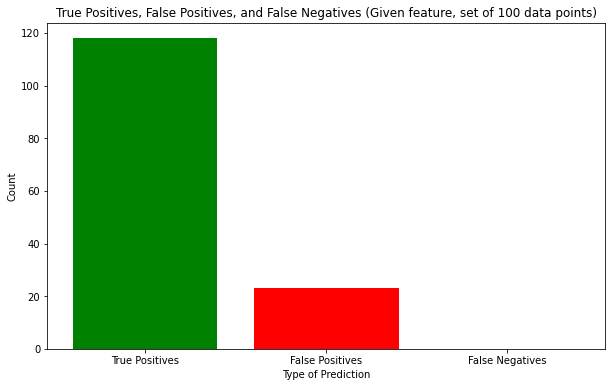

In [70]:
TP = 0
FP = 0
FN = 0

i = 0
with open(eval_file_path, 'r') as file:
    with open(file_path, 'r') as f:
        for line, line2 in zip(file,f):
            
            content = json.loads(line)
            content2 = json.loads(line2)
            
            str = content['Response']
            parsed_data = parse_values(str)
            gtf, gtv = content2['Ground Truth Features'], content2['Ground Truth Values']
            gt = zip(content2['Ground Truth Features'], content2['Ground Truth Values'])
            
            # Get True Positives
            for (feature, value) in gt:
                if feature in parsed_data.keys() and value in parsed_data[feature]:
                    TP += 1
                    
            # Get False Positives
            for (key, val) in zip(parsed_data.keys(), parsed_data.values()):
                if key not in gtf:
                    FP += 1
                elif not contains_any(val, gtv):
                    FP += 1
                    
            # Get False Negatives
            for (feature, value) in gt:
                if feature not in parsed_data.keys():
                    FN += 1
                  
                   

print(TP, FP, FN) 
# bar plot with varying colors
plt.figure(figsize=(10, 6))
plt.bar(['True Positives', 'False Positives', 'False Negatives'], [TP, FP, FN], color=['green', 'red', 'blue'])
plt.xlabel('Type of Prediction')
plt.ylabel('Count')
plt.title('True Positives, False Positives, and False Negatives (Given feature, set of 100 data points)')
plt.show()

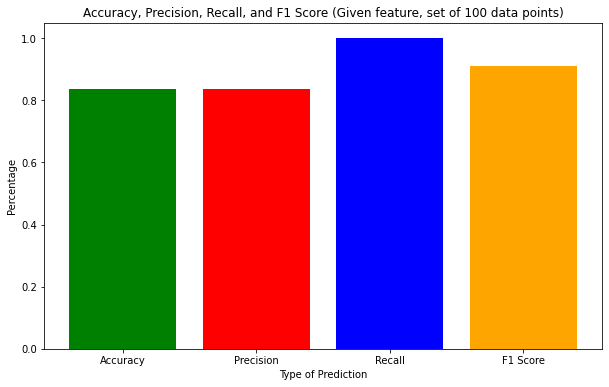

In [73]:
accuracy = TP / (TP + FP + FN)
precisions = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precisions * recall) / (precisions + recall)

plt.figure(figsize=(10, 6))
plt.bar(['Accuracy', 'Precision', 'Recall', 'F1 Score'], [accuracy, precisions, recall, f1], color=['green', 'red', 'blue', 'orange'])
plt.xlabel('Type of Prediction')
plt.ylabel('Percentage')
plt.title('Accuracy, Precision, Recall, and F1 Score (Given feature, set of 100 data points)')
plt.show()

In [69]:
TP = 0
FP = 0
FN = 0

i = 0
with open('eval.jsonl', 'r') as file:
    with open(file_path, 'r') as f:
        for line, line2 in zip(file,f):
            
            content = json.loads(line)
            content2 = json.loads(line2)
            
            str = content['Response']
            parsed_data = parse_values(str)
            gtf, gtv = content2['Ground Truth Features'], content2['Ground Truth Values']
            gt = zip(content2['Ground Truth Features'], content2['Ground Truth Values'])
            
            # Get True Positives
            for (feature, value) in gt:
                if feature in parsed_data.keys() and value in parsed_data[feature]:
                    TP += 1
                    
            # Get False Positives
            for (key, val) in zip(parsed_data.keys(), parsed_data.values()):
                if key not in gtf:
                    FP += 1
                elif not contains_any(val, gtv):
                    FP += 1
                    
            # Get False Negatives
            for (feature, value) in gt:
                if feature not in parsed_data.keys():
                    FN += 1
                  
                   

print(TP, FP, FN) 
plt.bar(['True Positives', 'False Positives', 'False Negatives'], [TP, FP, FN])
plt.title('Evaluation Given Features')
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
accuracy = TP / (TP + FP + FN)
precisions = TP / (TP + FP)
recall = TP / (TP + FN)

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precisions, recall])